In [2]:
import os
import time
import nltk
import torch
import string
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms as T
import torchvision.models as models 
from PIL import Image, ImageDraw, ImageFont
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d adityajn105/flickr8k
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

Defining constant values and paths

In [3]:
IMAGES_PATH = './Images/'
ANNOTATION_FILE = './captions.txt'
START_WORD, END_WORD, PADDING_WORD, UNKNOWN_WORD = '<SOS>', '<EOS>', '<PAD>', '<UNK>'
GUID_TOKENS = [START_WORD, END_WORD, PADDING_WORD, UNKNOWN_WORD]

In [4]:
class Dictionary():
  def __init__(self):
    self.max_cap_len = 0 
    self.idx2token = {0: START_WORD, 1: END_WORD, 2: PADDING_WORD, 3: UNKNOWN_WORD}
    self.token2idx = {v:k for k,v in self.idx2token.items()}

  def add_token(self, sentence_list):
    idx = max(list(self.idx2token.keys()))
    for sentence in sentence_list:
      for word in self.tokenize(sentence):
        if word not in self.token2idx:
          idx += 1
          self.token2idx[word] = idx
          self.idx2token[idx] = word

  def tokenize(self, text):
    tokens = list(
        filter(
            len, 
            text.translate(
                str.maketrans('', '', string.punctuation+'\n')
            ).lower().split()
        )
    )
    if len(tokens) > self.max_cap_len:
      self.max_cap_len = len(tokens)
    return tokens
    
  def numericalize(self, text):
    tokenized_text = self.tokenize(text)
    return [ self.token2idx[token] if token in self.token2idx else self.token2idx[UNKNOWN_WORD] for token in tokenized_text ]

  def __len__(self): 
    return len(self.idx2token)
  
  def stringify(self, idxVec):
    return filter(
        lambda word: word not in [START_WORD, END_WORD, PADDING_WORD], 
         [ self.idx2token[idx] if idx in self.idx2token else UNKNOWN_WORD for idx in idxVec.tolist() ]
    )

In [5]:
class CustomDataset(utils.data.Dataset):
  def __init__(self, images_dir = IMAGES_PATH, captions_file = ANNOTATION_FILE, transform=None, mode='train', train_test_split=0.1):
    self.images_dir = images_dir
    self.df = pd.read_csv(captions_file)
    self.transform = transform
    self.images = self.df["image"]
    self.captions = self.df["caption"]
    self.dictionary = Dictionary()
    self.dictionary.add_token(self.captions.tolist())
    self.mode = mode
    self.train_test_split = train_test_split

  
  def generate_caption_vector(self):
    caption = []
    caption += [self.dictionary.token2idx[START_WORD]]
    caption += self.dictionary.numericalize(caption)
    caption += [self.dictionary.token2idx[END_WORD]]
    return caption

  def get_image(self, idx):
    img_name = self.images[idx]
    img_location = os.path.join(self.images_dir,img_name)
    img = Image.open(img_location).convert("RGB")
    return img
    
  def __getitem__(self,idx):
    if self.mode != 'train':
      idx = len(self) - idx
    caption = self.captions[idx]
    img = self.get_image()
    if self.transform is not None:
      img = self.transform(img)
    caption_vector = self.generate_caption_vector();
    return img, torch.tensor(caption_vector)

  def __len__(self):
    return int(len(self.df) * (1 - self.train_test_split)) if self.mode == 'train' else int(len(self.df) * self.train_test_split)

In [6]:
class CapsCollate():
  def __init__(self, pad_idx, batch_first=False):
    self.pad_idx = pad_idx
    self.batch_first = batch_first

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]
    imgs = torch.cat(imgs,dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value = self.pad_idx)
    return imgs, targets

In [7]:
BATCH_SIZE = 256
NUM_WORKER = 1

dataset =  CustomDataset(transform=T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor()
]))

dictionary_size = len(dataset.dictionary)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_cap_len = dataset.dictionary.max_cap_len

data_loader = utils.data.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKER,
    shuffle = True,
    collate_fn = CapsCollate(
        pad_idx=dataset.dictionary.token2idx[PADDING_WORD], 
        batch_first=True
    )
)

In [12]:
def show_image(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  plt.imshow(inp)
  if title is not None:
    toks = dataset.dictionary.stringify(title)
    caption = ' '.join(toks)
    plt.title(caption)
  plt.pause(0.003)  

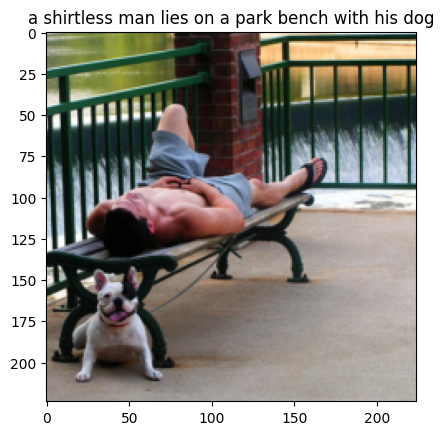

In [15]:
import random
random.seed(1)

img, caps = dataset[int(random.randint(1,100))]
show_image(img,caps)

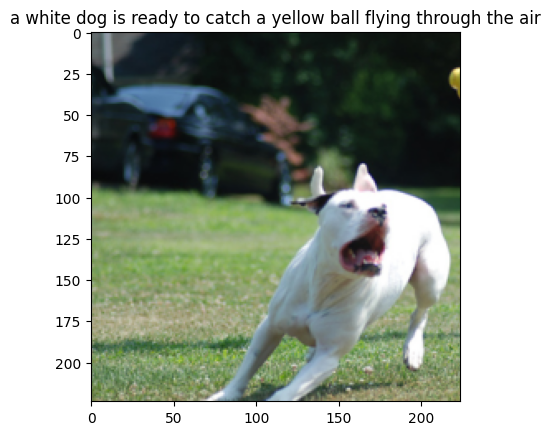

In [16]:
img, caps = dataset[int(random.randint(1,100))]
show_image(img,caps)

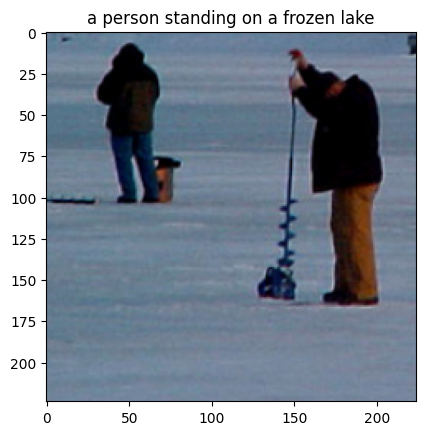

In [17]:
img, caps = dataset[int(random.randint(1,100))]
show_image(img,caps)

In [18]:
class CNN_Model(nn.Module):
  def __init__(self, embed_size, freeze = True):
    super(CNN_Model, self).__init__()
    resnet = models.resnet18(pretrained=True)

    self.embed.bias.data.fill_(0)
    self.embed.weight.data.normal_(0., 0.02)
    self.embed = nn.Linear(resnet.fc.in_features, embed_size)
    

    self.batch= nn.BatchNorm1d(
        embed_size,
        momentum = 0.01
    )

    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)

    if freeze:
      for param in resnet.parameters():
        param.requires_grad_(False)

    
        
  def forward(self, images):
    features = self.resnet(images)
    return self.batch(self.embed(features.view(features.size(0), -1)))

In [19]:
class LSTM_Model(nn.Module):
  def __init__(self, dictionary_size, embed_size = 300, hidden_size = 256, num_layers=1):
    super(LSTM_Model, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.embed_size= embed_size
    
    self.embed = nn.Embedding(self.dictionary_size, self.embed_size)
    self.embed.weight.data.uniform_(-0.1, 0.1)

    self.lstm = nn.LSTM(self.embed_size, self.hidden_size , self.num_layers, batch_first=True)
    self.dictionary_size = dictionary_size
    self.linear = nn.Linear(hidden_size, self.dictionary_size)

    self.linear.weight.data.uniform_(-0.1, 0.1)
    self.linear.bias.data.fill_(0)
    
  def forward(self, features, captions):
    embeddings = self.embed(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings[:, :-1,:]), dim=1)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

In [20]:
class ImageCaptioningModel(nn.Module):
  def __init__(self, dictionary_size, embed_size = 300, hidden_size = 256, freeze = True):
    super(ImageCaptioningModel, self).__init__()
    self.cnn = CNN_Model(embed_size = embed_size, freeze = freeze)
    self.lstm = LSTM_Model(dictionary_size = dictionary_size, embed_size = embed_size, hidden_size = hidden_size)

  def forward(self, images, captions):
    return self.lstm(self.cnn(images), captions)

In [40]:
def eval_model(model, data_loader, criterion, device):
  model.eval()
  data_loader.dataset.mode = 'test'
  loss = 0.0

  for idx ,(image, caption) in enumerate(iter(data_loader)):
    image = image.to(device)
    caption = caption.to(device)
    raw_cap = [dataset.dictionary.token2idx[PADDING_WORD] for _ in range(caption.size(dim=1))]
    raw_cap = torch.tensor([raw_cap])
    raw_cap = raw_cap.to(device)
    result = None

    for i in range(len(caption)):
      result = model(image, raw_cap)
      result_t = result.contiguous().view(-1, dictionary_size)
      raw_cap = result_t
      raw_cap = raw_cap.to(device)
      
    loss_val = criterion(result.contiguous().view(-1, dictionary_size), caption.view(-1))
    loss += loss_val.item()
  return loss / len(data_loader)

In [46]:
def train_model(model, epochs, optimizer, criterion, data_loader, val_data_loader, device):
  steps = len(val_data_loader.dataset) / BATCH_SIZE
  history_loss = []
  history_loss_val = []
  oldtime = time.time()
  loss = 0

  for epoch in range(1, epochs + 1):
    oldtime = time.time()
    data_loader.dataset.mode = 'train'
    model.train()

    for idx, (image, captions) in enumerate(iter(data_loader)):
      image = image.to(device)
      captions = captions.to(device)
      model.zero_grad()
      outputs = model(image, captions)
      loss = criterion(outputs.contiguous().view(-1, dictionary_size), captions.view(-1))
      loss.backward()
      optimizer.step()
      stats = 'Epoch %d/%d -- Step %d/%d -- loss: %.4f' % (epoch, epochs, idx, steps, loss.item())
      print('\r' + stats, end="")
      
    train_time = time.time()
    val_loss = eval_model(model, val_data_loader, criterion, device)
    stats = ', val_loss: %.4f -- Time: %.3f s' % (val_loss, train_time - oldtime)
    print(stats)
    history_loss.append(loss.item())
    history_loss_val.append(val_loss)
  return history_loss, history_loss_val

In [47]:
EPOCHS = 10
learning_rate = 4e-4

model_freezed = ImageCaptioningModel(dictionary_size)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.dictionary.token2idx[PADDING_WORD])
optimizer = optim.Adam(model_freezed.parameters(), lr=learning_rate)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_loader_test = utils.data.DataLoader(
    dataset = dataset,
    batch_size = 1,
    num_workers = NUM_WORKER,
    shuffle = True,
    collate_fn = CapsCollate(pad_idx=dataset.dictionary.token2idx[PADDING_WORD], batch_first=True)
)
model_freezed.to(device)

ImgCap_Model(
  (cnn): CNN_Model(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-

Training model 1

In [48]:
loss_history, history_loss_val = train_model(
    model_freezed, 
    EPOCHS, 
    optimizer, 
    criterion, 
    data_loader, 
    data_loader_test, 
    device
)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 1/10 -- Step 142/142 -- loss: 4.8287

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

, val_loss: 4.7352 -- Time: 375.158 s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 2/10 -- Step 142/142 -- loss: 4.0830

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process': 
AssertionErrorcan only test a child process


, val_loss: 4.5658 -- Time: 370.835 s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3/10 -- Step 142/142 -- loss: 3.7391

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


, val_loss: 4.5962 -- Time: 371.500 s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 4/10 -- Step 142/142 -- loss: 3.6770

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


, val_loss: 4.6960 -- Time: 329.708 s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5/10 -- Step 142/142 -- loss: 3.0937

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


, val_loss: 4.7907 -- Time: 316.675 s


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 6/10 -- Step 142/142 -- loss: 3.2160

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f18f38ab5b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


, val_loss: 4.8659 -- Time: 315.381 s
Epoch 7/10 -- Step 142/142 -- loss: 3.3410, val_loss: 4.8940 -- Time: 313.093 s
Epoch 8/10 -- Step 142/142 -- loss: 3.0056, val_loss: 4.9332 -- Time: 315.665 s
Epoch 9/10 -- Step 142/142 -- loss: 2.9786, val_loss: 4.9892 -- Time: 314.570 s
Epoch 10/10 -- Step 142/142 -- loss: 3.0163, val_loss: 5.0564 -- Time: 316.294 s


error plot of model 1 training

In [55]:
def plot_loss(loss_history, history_loss_val):
  fig = plt.figure()
  plt.plot([loss for loss in loss_history], color='blue', linewidth=2, label='train loss')
  plt.plot([loss for loss in history_loss_val], color='crimson', linewidth=2, label='validation loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.grid()
  plt.show()

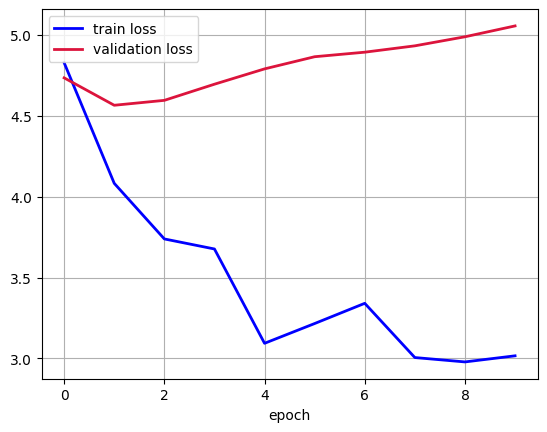

In [57]:
plot_loss(loss_history, history_loss_val)

In [50]:
model_freezed.eval()

ImgCap_Model(
  (cnn): CNN_Model(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-

In [ ]:
def predict_caption(data_loader_test, model):
    max_cap_len = dataset.dictionary.max_cap_len
    for idx, (images, captions) in enumerate(iter(data_loader_test)):
      images = images.to(device)
      captions = captions.to(device)
      raw_cap = [dataset.dictionary.token2idx[PADDING_WORD] for _ in range(max_cap_len)]
      raw_cap = torch.tensor([raw_cap])
      raw_cap = raw_cap.to(device)
      result = None
      for i in range(max_cap_len):
        result = model_freezed(images, raw_cap)
        result = [i.argmax() for i in result.cpu().data.numpy()[0]]
        raw_cap = torch.tensor([result])
        raw_cap = raw_cap.to(device)
      show_image(images.cpu().data[0], raw_cap[0])
      if idx >= 4:
        break

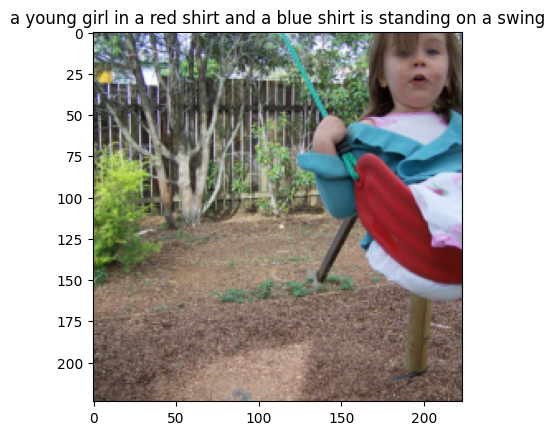

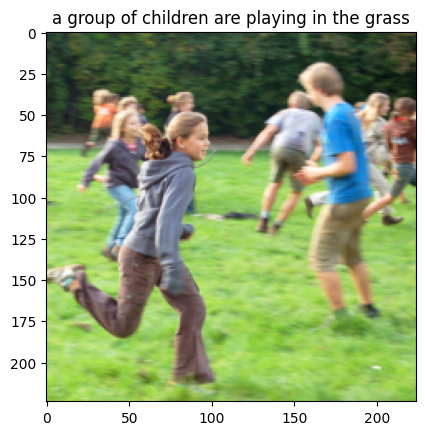

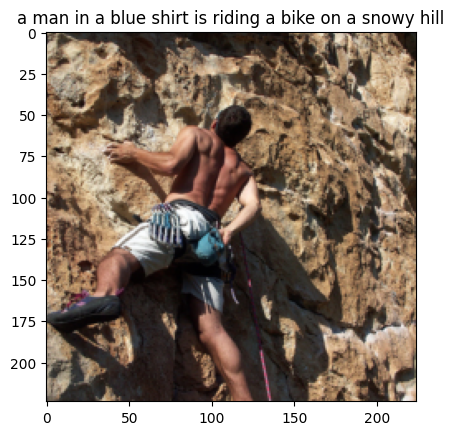

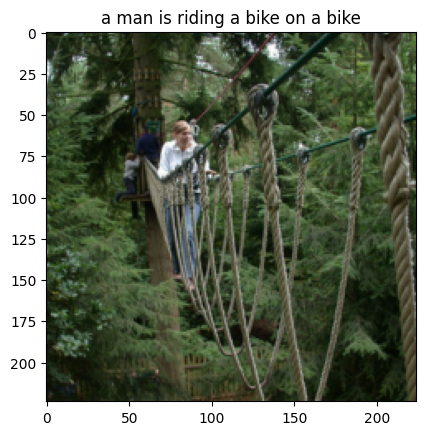

In [51]:
predict_caption(data_loader_test, model_freezed)


Model 2

Unfreeze Layers

In [52]:
model_unfreezed = ImageCaptioningModel(dictionary_size, freeze = False)

dataset.mode = 'train'

data_loader_un = utils.data.DataLoader(
    dataset = dataset,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKER,
    shuffle = True,
    collate_fn = CapsCollate(
        pad_idx=dataset.dictionary.token2idx[PADDING_WORD], 
        batch_first=True
    )
)

data_loader_test_un = utils.data.DataLoader(
    dataset = dataset,
    batch_size = 1,
    num_workers = NUM_WORKER,
    shuffle = True,
    collate_fn = CapsCollate(
        pad_idx=dataset.dictionary.token2idx[PADDING_WORD], 
        batch_first=True
    )
)

criterion_un = nn.CrossEntropyLoss(ignore_index=dataset.dictionary.token2idx[PADDING_WORD])
optimizer_un = optim.Adam(model_unfreezed.parameters(), lr=learning_rate)

model_unfreezed.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImgCap_Model(
  (cnn): CNN_Model(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-

Training model 2

In [53]:
loss_history_un, val_loss_history_un = train_model(model_unfreezed, EPOCHS, optimizer_un, criterion_un, data_loader_un, data_loader_test_un, device)

Epoch 1/10 -- Step 142/142 -- loss: 4.6544, val_loss: 4.7039 -- Time: 341.591 s
Epoch 2/10 -- Step 142/142 -- loss: 4.2580, val_loss: 4.5990 -- Time: 337.101 s
Epoch 3/10 -- Step 142/142 -- loss: 3.8326, val_loss: 4.7119 -- Time: 331.116 s
Epoch 4/10 -- Step 142/142 -- loss: 3.8308, val_loss: 4.8479 -- Time: 330.268 s
Epoch 5/10 -- Step 142/142 -- loss: 3.2802, val_loss: 4.9531 -- Time: 332.990 s
Epoch 6/10 -- Step 142/142 -- loss: 3.3543, val_loss: 4.9280 -- Time: 329.025 s
Epoch 7/10 -- Step 142/142 -- loss: 3.2557, val_loss: 5.0128 -- Time: 329.510 s
Epoch 8/10 -- Step 142/142 -- loss: 2.9047, val_loss: 5.0468 -- Time: 333.161 s
Epoch 9/10 -- Step 142/142 -- loss: 3.0659, val_loss: 5.0471 -- Time: 331.343 s
Epoch 10/10 -- Step 142/142 -- loss: 3.0388, val_loss: 5.0500 -- Time: 338.069 s


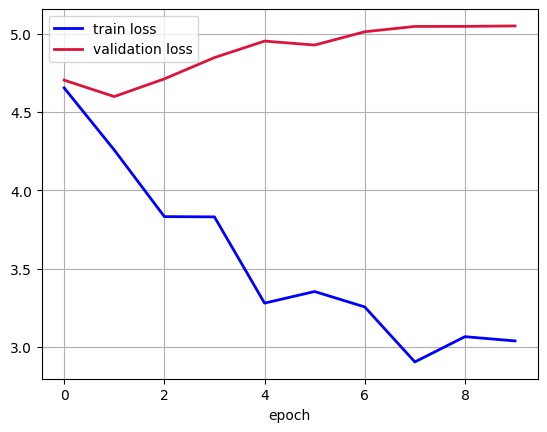

In [56]:
plot_loss(loss_history_un, val_loss_history_un)

In [58]:
model_unfreezed.eval()

ImgCap_Model(
  (cnn): CNN_Model(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-

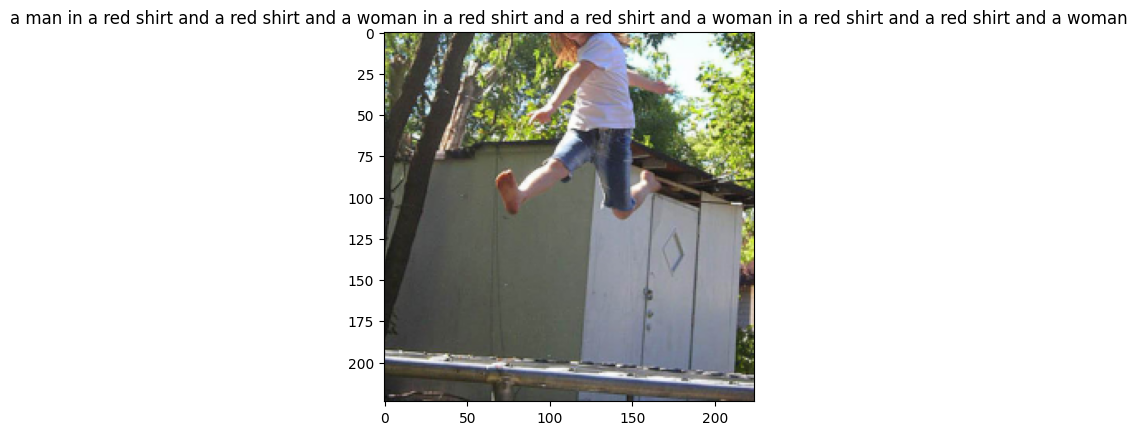

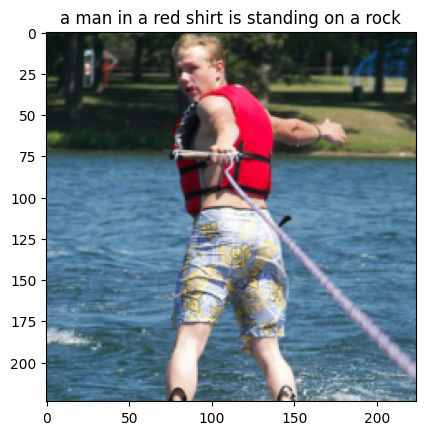

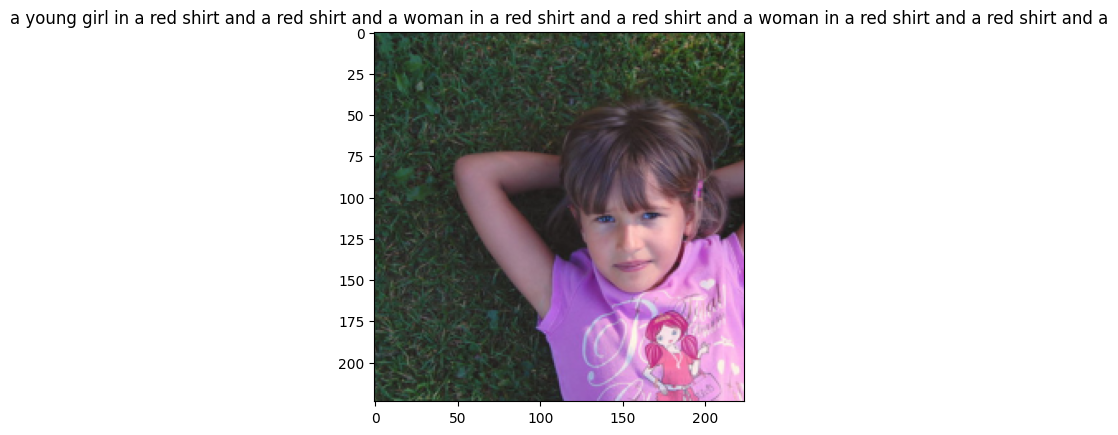

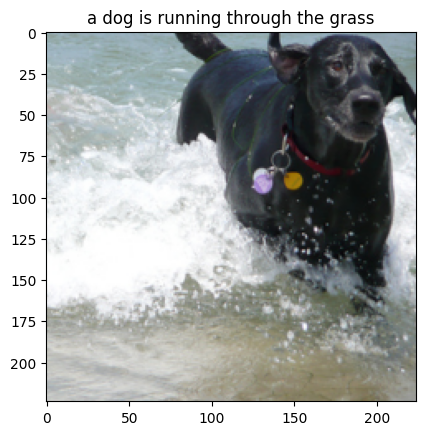

In [59]:
predict_caption(data_loader_test_un, model_unfreezed)